## Workflow for scATAC-Seq data

In [1]:
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import scarf
scarf.__version__

'0.7.2'

time: 860 ms


---
### 1) Fetch and convert data

In [2]:
scarf.fetch_dataset('tenx_10K_pbmc_atacseq', save_path='scarf_datasets')
reader = scarf.CrH5Reader('scarf_datasets/tenx_10K_pbmc_atacseq/data.h5', 'atac')
reader.assayFeats

INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/tenx_10K_pbmc_atacseq/data.h5


,ATAC
type,Peaks
start,0
end,90686
nFeatures,90686


time: 3.63 s


In [3]:
writer = scarf.CrToZarr(reader, zarr_fn=f'scarf_datasets/tenx_10K_pbmc_atacseq/data.zarr', chunk_size=(1000, 2000))
writer.dump(batch_size=1000)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

time: 11.5 s


---
### 2) Create DataStore and filter cells

In [4]:
ds = scarf.DataStore('scarf_datasets/tenx_10K_pbmc_atacseq/data.zarr', nthreads=4)

INFO: Setting assay ATAC to assay type: ATACassay
INFO: (ATAC) Computing nCells and dropOuts
[########################################] | 100% Completed |  1.3s
INFO: (ATAC) Computing nCounts
[########################################] | 100% Completed |  1.3s
INFO: (ATAC) Computing nFeatures
[########################################] | 100% Completed |  1.3s
time: 4.12 s


INFO: 296 cells flagged for filtering out using attribute ATAC_nCounts
INFO: 260 cells flagged for filtering out using attribute ATAC_nFeatures


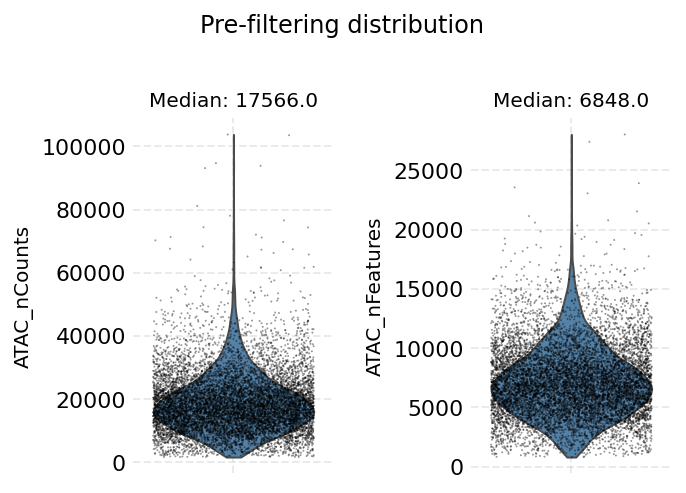

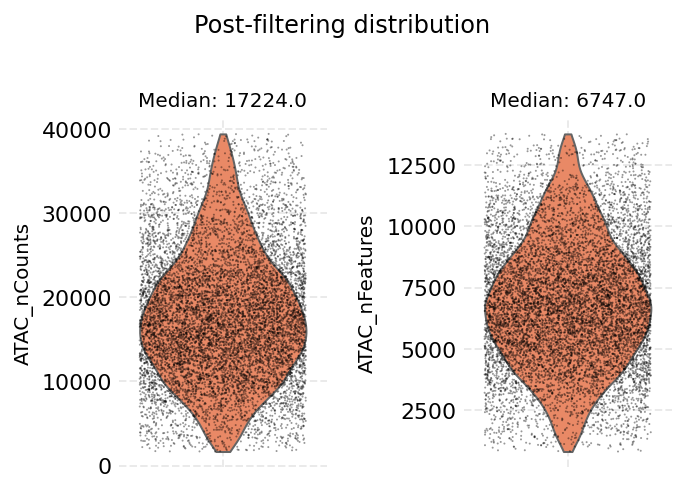

time: 1.2 s


In [5]:
ds.auto_filter_cells()

---
### 3) Feature selection

For scATAC-Seq data, the features are ranked by their TF-DF normalized values, summed across all cells. The top n features are marked as `prevalent_peaks` and are used for downstream step.

In [6]:
ds.mark_prevalent_peaks(top_n=20000)

INFO: (ATAC) Calculating peak prevalence across cells
[########################################] | 100% Completed |  3.4s
time: 3.5 s


---
### 4) KNN graph creation

For scATAC-Seq datasets, Scarf uses TF-IDF normalization. The normalization is automatically performed during the graph building step. The selected features, marked as `prevalent_peaks` in feature metadata, are used for graph creation. For the dimension reduction step, LSI (latent semantic indexing) is used rather than PCA. The rest of the steps are same as for scRNA-Seq data.

In [7]:
ds.make_graph(feat_key='prevalent_peaks', k=11, dims=21, n_centroids=1000)

INFO: No value provided for parameter `log_transform`. Will use default value: True
INFO: No value provided for parameter `renormalize_subset`. Will use default value: True
INFO: No value provided for parameter `pca_cell_key`. Will use default value: I
INFO: Using LSI for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5


Estimating seed partitions: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]

INFO: Saving loadings to ATAC/normed__I__prevalent_peaks/reduction__lsi__21__I
INFO: Saving ANN index to ATAC/normed__I__prevalent_peaks/reduction__lsi__21__I/ann__l2__50__50__48__4466
INFO: Saving kmeans clusters to ATAC/normed__I__prevalent_peaks/reduction__lsi__21__I/kmeans__1000__4466



Saving KNN graph: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]

INFO: ANN recall: 99.89%



Smoothening KNN distances: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

time: 1min 27s


---
### 5) UMAP reduction and clustering


Non-linear dimension reduction using UMAP and tSNE are performed in the same way as for scRNA-Seq data. SImilarly the clustering step is also performed in the same way as fr scRNA-Seq data.

In [8]:
ds.run_umap(fit_n_epochs=250, min_dist=0.5, parallel=True)

	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 10.2 s


In [9]:
ds.run_leiden_clustering(resolution=1)

time: 179 ms


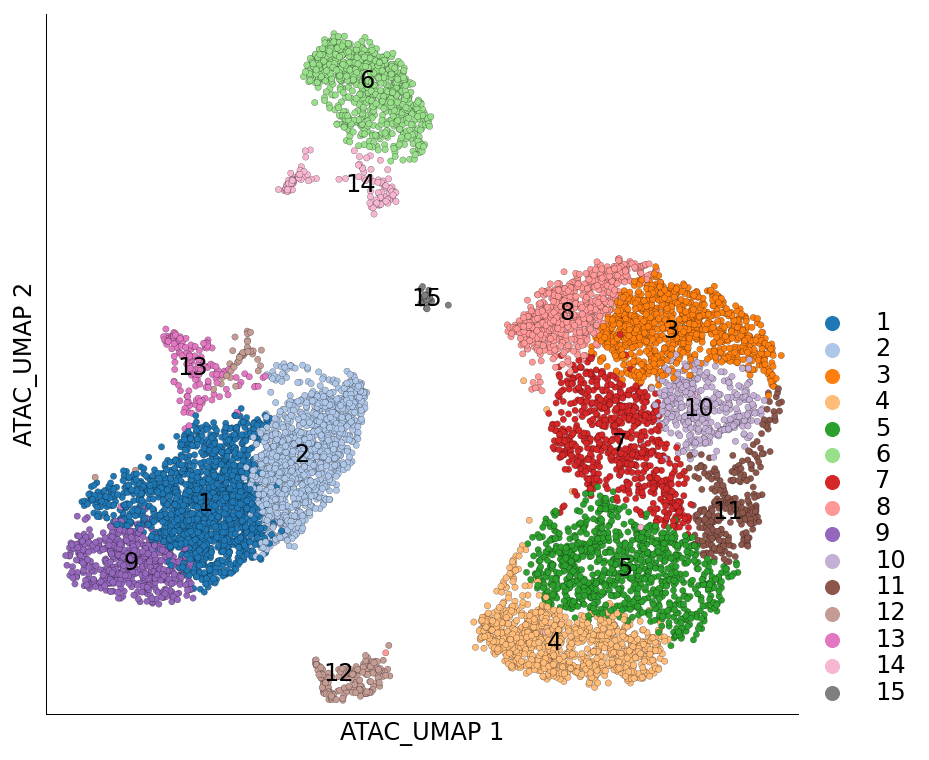

time: 576 ms


In [10]:
ds.plot_layout(layout_key='ATAC_UMAP', color_by='ATAC_leiden_cluster')

---
### 6) Calculating gene scores

This feature is coming soon..

In [11]:
ds.ATAC.feats.head()

,I,ids,names,I__prevalent_peaks,dropOuts,nCells,stats_I_prevalence
0,True,chr1:565163-565491,chr1:565163-565491,False,9619,49,0.123722
1,True,chr1:569190-569620,chr1:569190-569620,False,9545,123,0.299672
2,True,chr1:713551-714783,chr1:713551-714783,True,6403,3265,2.214712
3,True,chr1:752418-753020,chr1:752418-753020,False,9102,566,0.557693
4,True,chr1:762249-763345,chr1:762249-763345,True,7433,2235,1.673136


time: 22.7 ms


In [12]:
# scf.meld_assay(ds.ATAC, gene_bed, out_name='GeneActivity', peaks_col='peak_coords',
#                nthreads=6, ignore_ids=blacklist_peaks)

time: 154 µs


---
That is all for this vignette.